# Journal Article Selection - Invasive Carp
This project aimed to explore how effective machine learning classification is at selecting relevant journal articles related to invasive silver and bighead carp.

* This was a preliminary, exploratory project meant to be a trial run for GLANSIS.

## Import libraries and data

In [38]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import pickle
import warnings

from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

import warnings

In [7]:
# Import data
df = pd.read_csv(r'..\data\processed\train-test.csv')
df.head()  # TitleAbstract column contains preprocessed text data


,Author,Year,Title,Journal Name,Volume,Issue,Pages,Abstract,categories,TitleAbstract
0,"Aldridge, C. A., and E. C. Boone",2022,Simple models to quickly estimate the probable...,River Research and Applications,38,6,1154-1166,Species distribution models provide biologists...,1,simpl model quick estim probabl rang datalimit...
1,"Banan, A., A. Nasiri, and A. Taheri-Garavand",2020,Deep learning-based appearance features extrac...,Aquacultural Engineering,89,NaN,NaN,Fish species identification is vital for aquac...,1,deep learningbas appear featur extract autom c...
2,"Barnes, M. A., W. L. Chadderton, C. L. Jerde, ...",2021,Environmental conditions influence edna partic...,Environmental DNA,3,3,643-653,Knowledge about the size of environmental DNA ...,1,environment condit influenc edna particl size ...
3,"Behera, B. K., A. K. Bera, P. Paria, A. Das, P...",2018,Identification and pathogenicity of plesiomona...,Aquaculture,493,NaN,314-318,Plesiomonas shigelloides was isolated from dis...,1,identif pathogen plesiomona shigelloid silver ...
4,"Borland, L. K., C. J. Mulcahy, B. A. Bennie, D...",2020,Using markov chains to quantitatively assess m...,Natural Resource Modeling,33,4,NaN,Natural resource managers use barriers to dete...,1,use markov chain quantit assess movement patte...


## Clean text data

In [9]:
# Create label encoder 
label_encoder = LabelEncoder()
df["categories"] = label_encoder.fit_transform(df['categories'])


In [11]:
df["categories"].value_counts()

categories
0    408
1    233
Name: count, dtype: int64

#### Balancing Dataset: 
I want to prioritize the reduction of false negatives when selecting relevant articles. I decided to balance dataset to give mode a better chance of learning to detect relevant articles.


In [13]:
# Create balanced datasets for article selection
balanced_dfs = []

# Count the number of rows in each category
category_counts = df['categories'].value_counts()

# Find the minority category
minority_category = category_counts.idxmin()

# Get the size of the minority category
minority_category_size = category_counts[minority_category]

# Sample rows from the majority category to match the size of the minority category
majority_category_rows = df[df['categories'] != minority_category]
balanced_majority_category_rows = majority_category_rows.sample(n=minority_category_size, random_state=42)

# Get the minority category rows
minority_category_rows = df[df['categories'] == minority_category]

# Concatenate the minority and balanced majority category rows
balanced_df = pd.concat([minority_category_rows, balanced_majority_category_rows])

balanced_dfs.append(balanced_df)
balanced_df['categories'].value_counts()


categories
1    233
0    233
Name: count, dtype: int64

## Trained and Tested Models
Used GridSearch to test different vectorizors and machine models with different parameters.

In [15]:
# Create X and y
X = balanced_df['TitleAbstract']
y = balanced_df['categories']


In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(balanced_df['TitleAbstract'], balanced_df['categories'], test_size = 0.2, random_state = 0)


In [19]:
# Define vectorizers
vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TFIDFVectorizer": TfidfVectorizer(),
}


In [21]:
# Define model parameters
models = {
    "LR": (LogisticRegression(), {
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        'model__C': [0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'lbfgs', 'saga'],
        'model__multi_class': ['ovr', 'multinomial'],
    }),
    "kNN": (KNeighborsClassifier(), {
        'model__n_neighbors': list(range(1, 21)),
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }),
    "SVM": (SVC(), {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': [1, 0.1, 0.01, 0.001],
        'model__kernel': ['linear', 'rbf', 'sigmoid'] # decided not to test 'poly'
    }),
    "Random Forest": (RandomForestClassifier(), {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    }),
    "Decision Tree": (DecisionTreeClassifier(), {
        'model__max_depth': [None, 2, 4, 6, 8],
        'model__min_samples_split': [2, 5, 10]
    })
}


In [36]:
# Initialize a dictionary to hold the best models
best_models = {}

# Grid Search for each vectorizer and model
for vec_name, vectorizer in vectorizers.items():
    for name, (model, params) in models.items():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            pipeline = Pipeline([
                ('vectorizer', vectorizer),
                ('model', model)
            ])
            
            grid_search = GridSearchCV(pipeline, params, cv = 10, scoring = 'recall')
            grid_search.fit(X_train, y_train) 
            best_models[f"{vec_name}_{name}"] = grid_search.best_estimator_  # Store the best model
            best_accuracy = grid_search.best_score_


#### Data table of results

In [27]:
# Evaluate the best models on the test set
metrics_list = []

for name, model in best_models.items():
    
    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = model.named_steps['vectorizer']
    classifier = model.named_steps['model']
    
    # Transform the test data
    X_test_vec = vectorizer.transform(X_test)  # Transform X_test with the same vectorizer used in training
    
    # Make predictions
    y_pred = classifier.predict(X_test_vec)
    
    # Compute metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 2)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 2)
    
    # Store metrics
    metrics = [name, accuracy, precision, recall, f1]
    metrics_list.append(metrics)
    
# Create a DataFrame with the results
column_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1']
result_df = pd.DataFrame(metrics_list, columns=column_names)
print(result_df)


                           Model  Accuracy  Precision  Recall    F1
0             CountVectorizer_LR      0.74       0.75    0.74  0.74
1            CountVectorizer_kNN      0.52       0.51    0.52  0.41
2            CountVectorizer_SVM      0.69       0.70    0.69  0.69
3  CountVectorizer_Random Forest      0.72       0.73    0.72  0.72
4  CountVectorizer_Decision Tree      0.49       0.51    0.49  0.41
5             TFIDFVectorizer_LR      0.78       0.78    0.78  0.78
6            TFIDFVectorizer_kNN      0.71       0.72    0.71  0.71
7            TFIDFVectorizer_SVM      0.77       0.77    0.77  0.77
8  TFIDFVectorizer_Random Forest      0.70       0.70    0.70  0.70
9  TFIDFVectorizer_Decision Tree      0.57       0.57    0.57  0.56


#### Plots: ROC Curves

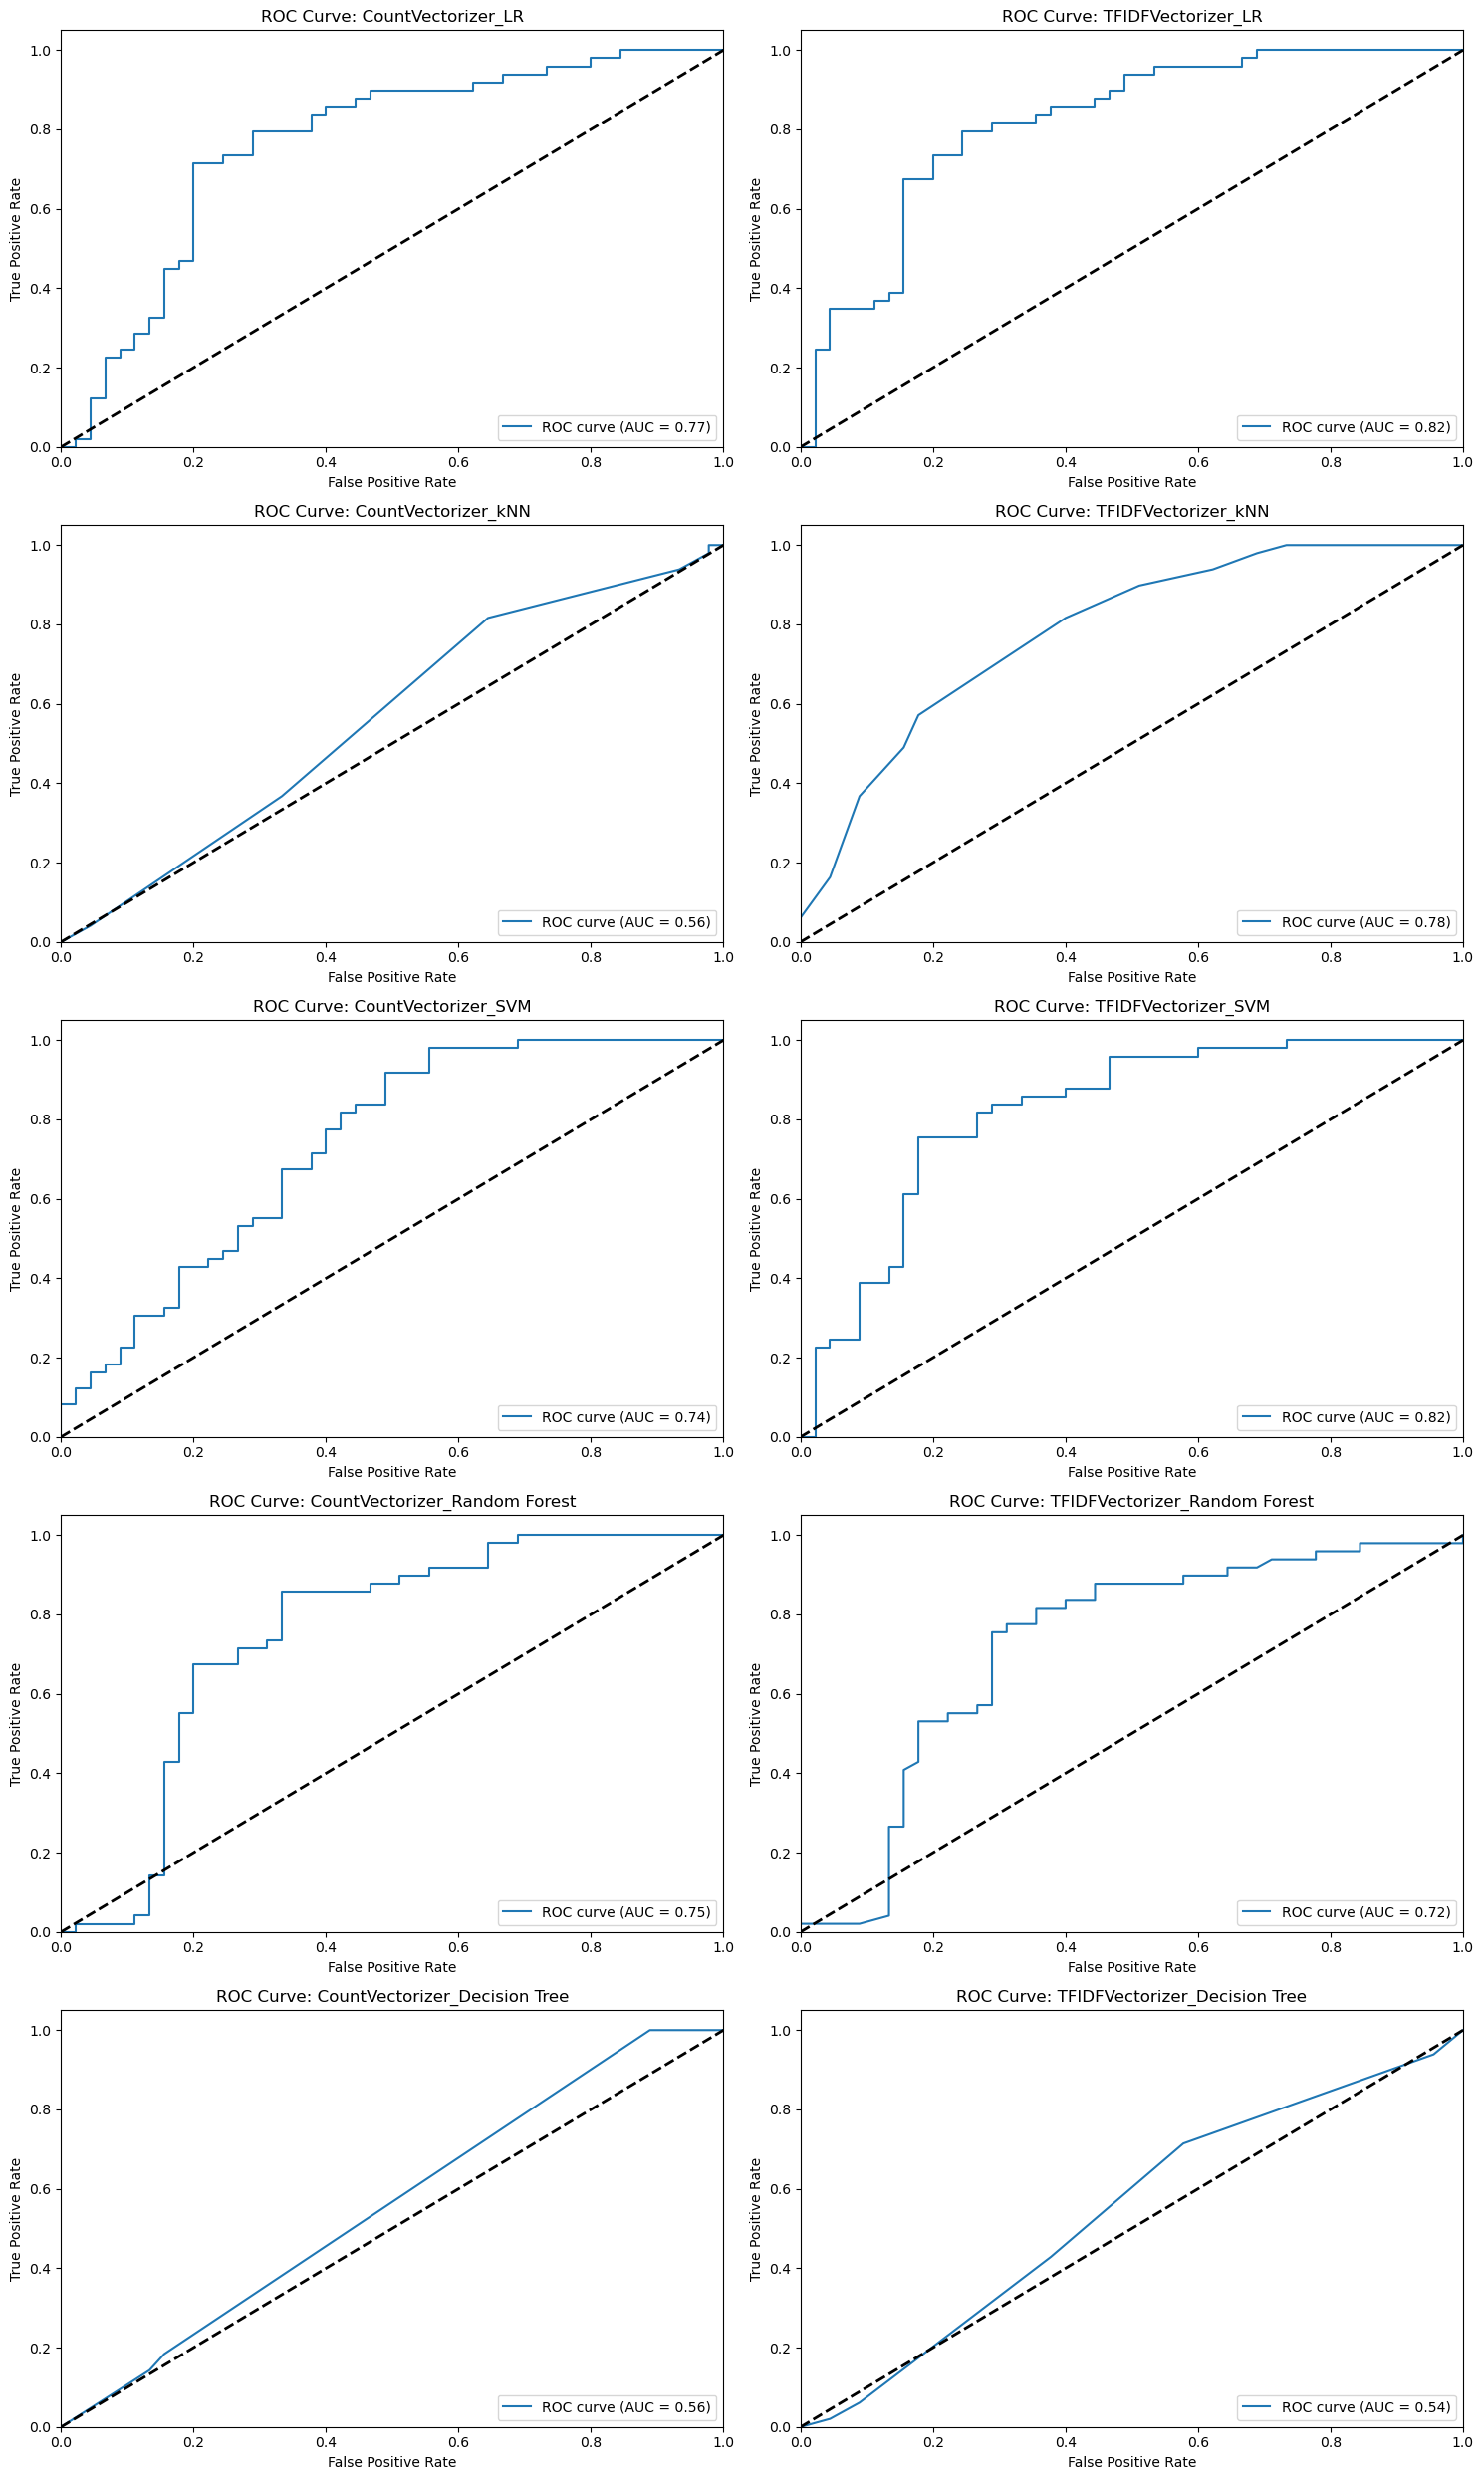

In [59]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curves for all models
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.T.flatten()

# Loop through models and vectorizers
for idx, (name, model) in enumerate(best_models.items()):
    ax = axes[idx]
    
    # Get the vectorizer and classifier from the pipeline
    vectorizer = model.named_steps['vectorizer']
    classifier = model.named_steps['model']
    
    # Transform the test data
    X_test_vec = vectorizer.transform(X_test)

    # Predict probabilities if classifier supports it
    if hasattr(classifier, "predict_proba"):
        y_score = classifier.predict_proba(X_test_vec)[:, 1]
    elif hasattr(classifier, "decision_function"):
        y_score = classifier.decision_function(X_test_vec)
    else:
        print(f"Model {name} does not support probability scores.")
        continue

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"ROC Curve: {name}")
    ax.legend(loc="lower right")

# Adjust layout
plt.tight_layout()
plt.show()


## Export Best Model
I want to reduce the number false negatives (i.e. losing articles that are relevant). Therefore, I decided to use recall and not accuracy as the best metric for articles selection.

In [33]:
# Select best model
top_model_index = result_df['Recall'].idxmax()  # find the index of the model with max recall
top_model = result_df.loc[top_model_index, 'Model']  # extract the model name corresponding to the index
best_model = best_models.get(top_model)
best_model


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=1, multi_class='ovr',
                                    solver='liblinear'))])

In [27]:
# Save model
with open('../models/ml_model.pkl', 'wb') as file:
    pickle.dump((best_model, vectorizer), file)

## Notes on how to improve:
1. More articles, particularly articles that relevant to GLANSIS.
2. Pull text from PDFs? This might make processing time even longer though.
3. Test more advanced vectorizors, like Word2Vec.
4. Record model speed?